# Regridding to a reference cell size using interpolation

The goal of this notebook is to demonstrate basic regridding to a specific scale (km) using interpolation and averaging of the variable (sea surface temperature).

### Description
This notebook uses multidimensional interpolation from the [xarray](http://xarray.pydata.org/en/stable/generated/xarray.Dataset.interp.html) library. This approach is useful in that it allows the user to pass a custom grid.

## Setup

First run:

```
# download files from S3
wget https://jataware-world-modelers.s3.amazonaws.com/analytic-layers/gadm_0.zip
wget https://jataware-world-modelers.s3.amazonaws.com/analytic-layers/sample_2.nc

# unzip gadm and gpw
unzip gadm_0.zip

# remove zip files
rm *.zip
```


### Requirements
```
geopandas==0.9.0
matplotlib==3.4.2
numpy==1.20.3
xarray==0.19.0

```

In [1]:
%matplotlib inline

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from cdo import * 
import os
os.environ['HDF5_DISABLE_VERSION_CHECK'] = "1"

cdo = Cdo()
cdo.debug = False

### Load and examine the netCDF datset using xarray.

In [4]:
model_output = xr.open_dataset('sample.nc',decode_coords="all")
model_output = model_output.rio.write_crs(4326)

# Drop time variables; for some reason clipping these is problematic...
model_output = model_output[['harvested_area','harvest','production']]

In [6]:
shapefile = 'gadm_0/gadm36_0.shp'
sf = gpd.read_file(shapefile)

In [8]:
gpw = xr.open_dataset('gpw_v4_2pt5_min.nc',decode_coords="all")
gpw = gpw.rio.write_crs(4326)
var_name = list(gpw.data_vars.keys())[0]

In [9]:
countries = ['Ethiopia','South Sudan','Somalia','Kenya']
countries_shp = sf[sf['NAME_0'].isin(countries)]
countries_shp.geometry

71     POLYGON ((38.75982 3.55447, 38.74260 3.55950, ...
117    MULTIPOLYGON (((39.37625 -4.71569, 39.37625 -4...
202    MULTIPOLYGON (((41.61375 -1.60792, 41.61375 -1...
205    POLYGON ((31.59829 3.68959, 31.59059 3.68719, ...
Name: geometry, dtype: geometry

### Write model_output to tmp netcdf

In [10]:
gpw_c = gpw.rio.clip(countries_shp.geometry)
gpw_c.to_netcdf('gpw_tmp.nc')

model_output_c = model_output.rio.clip(countries_shp.geometry)
model_output_c.to_netcdf('sample_tmp.nc')

In [11]:
cdo.sinfon(input = "sample_tmp.nc",  output =  "")

['File format : NetCDF4 zip',
 '-1 : Institut Source   T Steptype Levels Num    Points Num Dtype : Parameter name',
 '1 : unknown  unknown  v instant      26   1      2052   1  F32z : harvested_area',
 '2 : unknown  unknown  v instant      26   1      2052   1  F32z : harvest',
 '3 : unknown  unknown  v instant      26   1      2052   1  F32z : production',
 'Grid coordinates :',
 '1 : lonlat                   : points=2052 (54x38)',
 'mapping : latitude_longitude',
 'longitude : 24.75 to 51.25 by 0.5 degrees_east',
 'latitude : 14.25 to -4.25 by -0.5 degrees_north',
 'Vertical coordinates :',
 '1 : generic                  : levels=26',
 'Time coordinate :  4 steps',
 'YYYY-MM-DD hh:mm:ss  YYYY-MM-DD hh:mm:ss  YYYY-MM-DD hh:mm:ss  YYYY-MM-DD hh:mm:ss',
 '2021-01-01 00:00:00  2021-01-01 00:00:00  2022-01-01 00:00:00  2022-01-01 00:00:00']

In [13]:
#regrid = cdo.setgrid('targetgrid', input='sample_tmp.nc', returnXDataset = True)

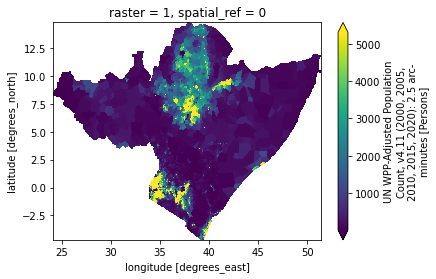

In [18]:
var_name = list(gpw.data_vars.keys())[0]
gpw_c\
    .isel(raster=0)\
    [var_name]\
    .plot(robust=True)
gpw_c.to_netcdf('gpw_tmp.nc')

In [16]:
regrid = cdo.remapbil("gpw_tmp.nc", input="sample_tmp.nc", options='-f nc', returnXDataset = True)

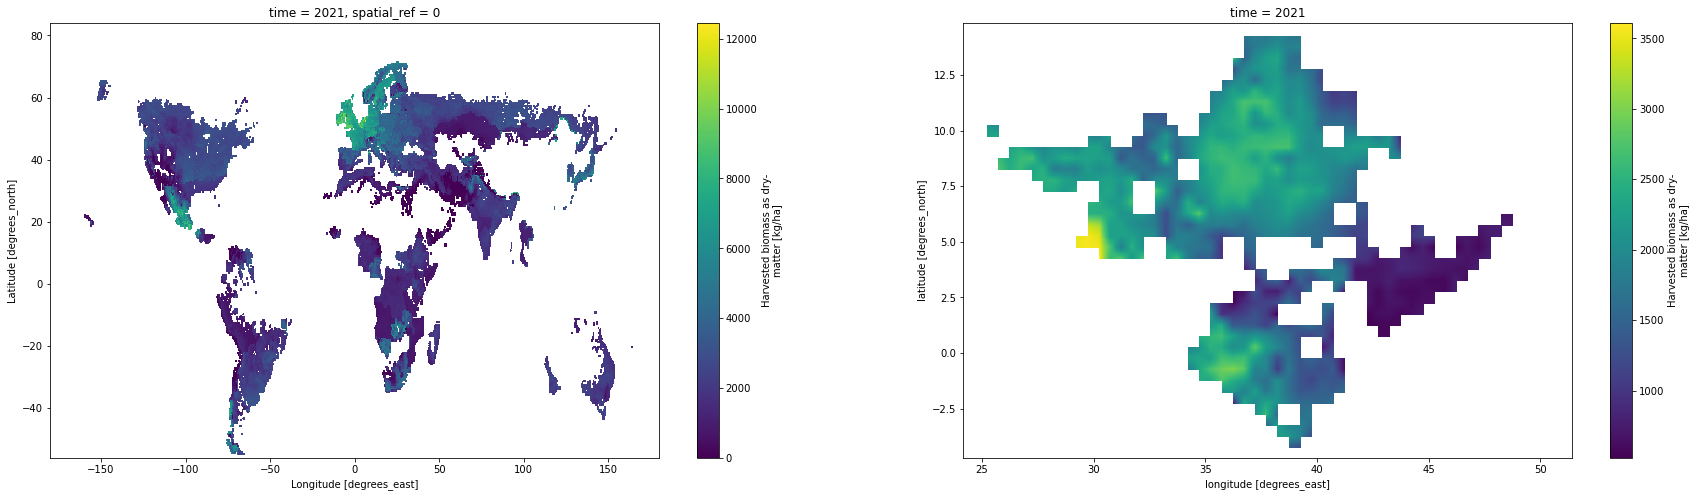

In [19]:
fig, axes = plt.subplots(ncols=2, figsize=(30, 8))

model_output.harvest[0,0,:,:].plot(ax=axes[0])
#axes[0].set_title("55km resolution", fontsize = 18)
regrid.harvest[0,0,:,:].plot(ax=axes[1])
#axes[1].set_title("500km resolution", fontsize = 18)
print()